In [10]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator #Data Augmentation
from tensorflow.keras.models import Sequential,Model #Model Olusturmak
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D #Katmanlari olusturmak
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers  import Concatenate
from tensorflow.keras.layers import AveragePooling2D, Dropout, Input, BatchNormalization
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from keras.preprocessing import image
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
import urllib.request
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score
from keras.layers import Input, Add, Dense,GlobalAvgPool2D, Concatenate, AvgPool2D, Dropout, ReLU, Activation, MaxPool2D, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, GlobalAveragePooling2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications import VGG16
from keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
import tensorflow as tf

In [11]:
train_dir = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/"
test_dir = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/"

In [12]:
class_names = os.listdir(train_dir)
batch_size=20

In [13]:
traindata= ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2,
                                   fill_mode='nearest')

testdata = ImageDataGenerator(rescale=1./255)

In [14]:
train_data_generator=traindata.flow_from_directory(train_dir,
                                                   batch_size=batch_size,
                                                   class_mode="categorical",
                                                   target_size=(224,224),
                                                   color_mode="rgb",
                                                   shuffle=True )


test_data_generator=testdata.flow_from_directory(test_dir,
                                                 batch_size=batch_size,
                                                 class_mode="categorical",
                                                 target_size=(224,224),
                                                 color_mode="rgb",
                                                 shuffle=False )

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [15]:
class_dict = train_data_generator.class_indices
class_list = list(class_dict.keys())
#class_list

In [16]:
train_number=train_data_generator.samples
test_number=test_data_generator.samples

In [17]:
vgg16_model = keras.applications.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)
vgg16_model.trainable = False
vgg16_model.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [18]:
inputs = keras.Input(shape=(224,224,3))

x = vgg16_model(inputs, training = False)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(4096, activation="relu")(x)
x = keras.layers.Dense(4096, activation="relu")(x)
prediction2 = Dense(38, activation = 'softmax')(x)
vgg16 = Model(inputs=inputs, outputs=prediction2)
vgg16.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [19]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            mode='max',
                                            verbose=1,
                                            patience=50,
                                            baseline=0.4,
                                            min_delta=0.0001,
                                            restore_best_weights=False)

In [20]:
history= vgg16.fit(train_data_generator,
                   validation_data= test_data_generator,
                   shuffle=True,
                   epochs =50,
                   batch_size=20,
                   callbacks=[callback])

3515/3515 [==============================] - 1181s 334ms/step - loss: 0.8813 - accuracy: 0.7330 - val_loss: 0.4474 - val_accuracy: 0.8527


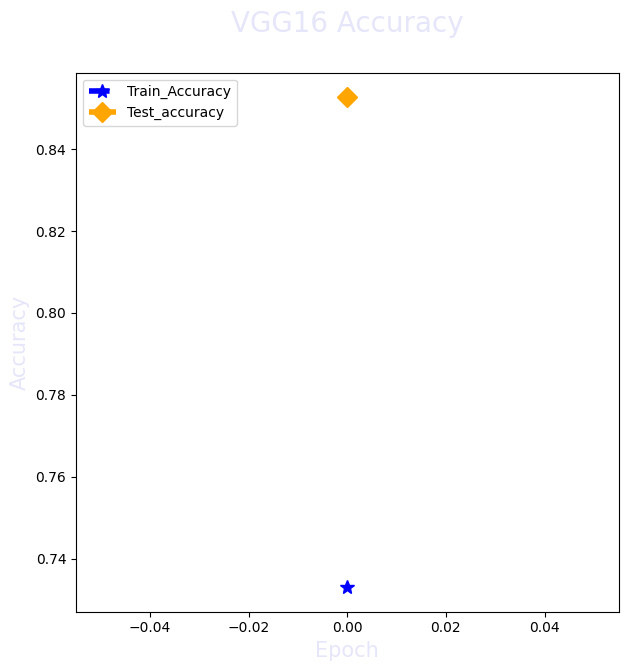

In [21]:
plt.figure(figsize=(7,7))
plt.plot(history.history['accuracy'],marker="*",linestyle="--",color="blue",markersize=10,lw=4)
plt.plot(history.history['val_accuracy'],marker="D",linestyle="-.",color="orange",markersize=10,lw=4)
plt.title('VGG16 Accuracy\n',color="lavender",fontsize=20)
plt.ylabel('Accuracy',color="lavender",fontsize=15)
plt.xlabel('Epoch',color="lavender",fontsize=15)
plt.legend(['Train_Accuracy', 'Test_accuracy'], loc='upper left')
plt.show()

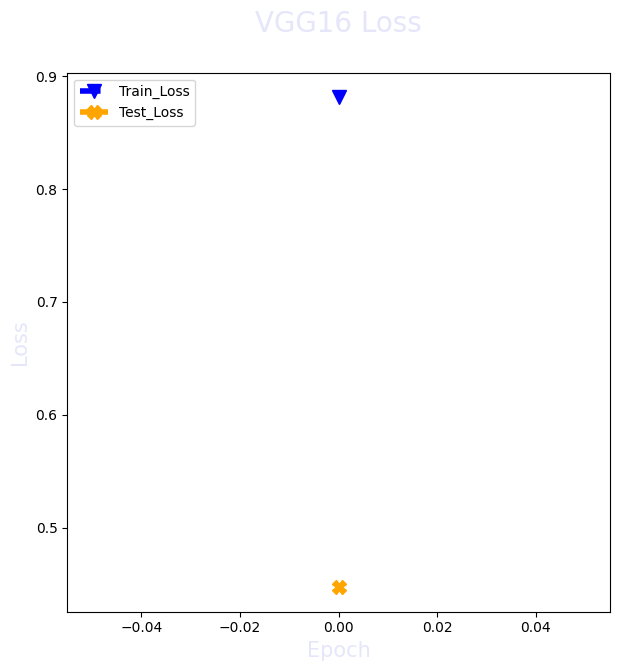

In [22]:
plt.figure(figsize=(7,7))
plt.plot(history.history['loss'],marker="v",linestyle="--",color="Blue",markersize=10,lw=4)
plt.plot(history.history['val_loss'],marker="X",linestyle="-.",color="Orange",markersize=10,lw=4)
plt.title('VGG16 Loss\n',color="lavender",fontsize=20)
plt.ylabel('Loss',color="lavender",fontsize=15)
plt.xlabel('Epoch',color="lavender",fontsize=15)
plt.legend(['Train_Loss', 'Test_Loss'], loc='upper left')
plt.show()

In [23]:
prediction=vgg16.predict(test_data_generator,steps=test_number//batch_size + 1)
final_predict=np.argmax(prediction,axis=1)
true_data=test_data_generator.classes

879/879 [==============================] - 91s 103ms/step


In [24]:
print("Accuracy Score is",accuracy_score(true_data,final_predict))

Accuracy Score is 0.852663328021853


In [25]:
print("ROC AUC Score is {}".format(roc_auc_score(true_data, prediction,multi_class='ovr')))

ROC AUC Score is 0.9966826324632065


In [ ]:
vgg16.save('vgg16.h5')

In [ ]:
plt.figure(figsize=(40,40))
cm= confusion_matrix(test_data_generator.classes,final_predict)
sns.heatmap(cm,  annot=True ,fmt="d",cmap="Blues",xticklabels=class_names,
            yticklabels=class_names,linewidth=4)
plt.title("Confusion_matrix\n",fontsize=20,color="black")
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.show()

In [ ]:
print(classification_report(test_data_generator.classes, final_predict,target_names=class_list))

In [ ]:
import random

class_name = list(test_data_generator.class_indices.keys())

image_indices = list(range(len(test_data_generator.filepaths)))
random.shuffle(image_indices)

plt.figure(figsize=(30, 30))
number_images = (5, 5)

for i in range(1, (number_images[0] * number_images[1]) + 1):
    plt.subplot(number_images[0], number_images[1], i)
    plt.axis("off")

    shuffled_index = image_indices[i - 1]

    true_label = class_name[test_data_generator.classes[shuffled_index]]
    predicted_label = class_name[final_predict[shuffled_index]]

    color = "green"
    if true_label != predicted_label:
        color = "red"

    plt.title(f"True: {true_label}\nPredicted: {predicted_label}", color=color)
    plt.imshow(plt.imread(test_data_generator.filepaths[shuffled_index]))

plt.show()